In [108]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import grid_search
from sklearn import metrics
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

# Load the dataset
df = pd.read_csv("../data/final/final.csv")

In [109]:
# Check head
df.head()

,year,decade,total_curses,curses,unique_words,density,most_used,creativity,charted
0,1961,1960,0,0,37,73,palac,0.506849,0
1,1961,1960,0,0,45,91,latest,0.494505,1
2,1961,1960,0,0,56,106,cloudi,0.528302,1
3,1961,1960,0,0,42,148,whirl,0.283784,1
4,1961,1960,0,0,29,132,salli,0.219697,1


In [113]:
df.describe()

,year,decade,total_curses,curses,unique_words,density,creativity,charted
count,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000
mean,1991.199795,1986.552254,1.178023,0.175461,62.340164,139.011527,0.484528,0.580943
std,13.556839,13.559383,4.894722,0.380410,36.348775,81.833969,0.163734,0.493468
min,1961.000000,1960.000000,0.000000,0.000000,1.000000,1.000000,0.057692,0.000000
25%,1981.000000,1980.000000,0.000000,0.000000,41.000000,85.000000,0.370117,0.000000
50%,1994.000000,1990.000000,0.000000,0.000000,54.000000,119.000000,0.463635,1.000000
75%,2003.000000,2000.000000,0.000000,0.000000,71.000000,168.000000,0.583608,1.000000
max,2010.000000,2010.000000,88.000000,1.000000,322.000000,655.000000,1.000000,1.000000


In [114]:
df.dtypes

year              int64
decade            int64
total_curses      int64
curses            int64
unique_words      int64
density           int64
most_used        object
creativity      float64
charted           int64
dtype: object

In [98]:
# Get pair plot for data
# sns.pairplot(df)

In [99]:
# Analyze unnormalized and normalized Charted by Curse Words

# Get group by counts for unnormalized charted by curses
df_by_curse_unnorm = pd.DataFrame()
df_by_curse_unnorm['curses'] = df[df['curses']==1]['charted'].value_counts()
df_by_curse_unnorm['no_curses'] = df[df['curses']==0]['charted'].value_counts()

In [100]:
# Get group by counts for normalized charted by curses
df_by_curse_normed = pd.DataFrame()
df_by_curse_normed['curses'] = df[df['curses']==1]['charted'].value_counts(normalize=True)
df_by_curse_normed['no_curses'] = df[df['curses']==0]['charted'].value_counts(normalize=True)

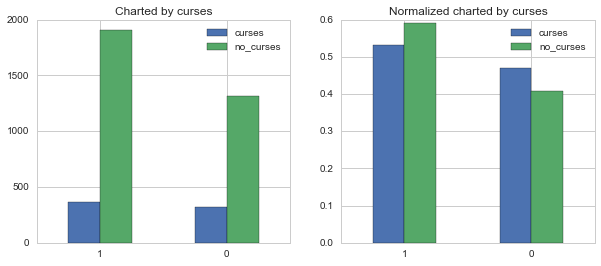

In [101]:
# Plot Unnormalized and Normalized Survival by Sex
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
df_by_curse_unnorm.plot(ax=ax1, kind='bar', rot=0, title="Charted by curses")
ax2 = fig.add_subplot(122)
df_by_curse_normed.plot(ax=ax2, kind='bar', rot=0, title="Normalized charted by curses")

In [102]:
# Check data types
print df.dtypes

year              int64
decade            int64
total_curses      int64
curses            int64
unique_words      int64
density           int64
most_used        object
creativity      float64
charted           int64
dtype: object


In [103]:
# def pre_proc(df):
#     # Create dummy variables for all non-numerical columns
    
#     # Get dummy variables for charted
#     df = df.join(pd.get_dummies(df['curses'], prefix='curses'))
#     # Remove charted column
#     df = df.drop(['curses'], axis=1)
    
#     return df

In [104]:
# # Apply pre_proc() to DF
# df = pre_proc(df)

# # Check cleaned data
# df.head()

In [105]:
# Set target variable name
target = 'charted'

# Set X and y
X = df.drop([target], axis=1)
y = df[target]

In [106]:
# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=1000
)

In [107]:
# Instantiate logistic regression classifier using default params
lm = linear_model.LogisticRegression()

# Train logistic regression classifier on training set
lm.fit(X_train, y_train)

ValueError: could not convert string to float: market

In [85]:
# Check model accuracy on test set
print "Accuracy: %0.3f" % lm.score(X_test, y_test)

Accuracy: 0.677


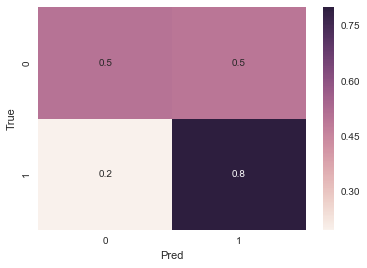

Confusion Matrix:
[[330 326]
 [178 728]]


In [86]:
# Get confusion matrix on test set
y_pred = lm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

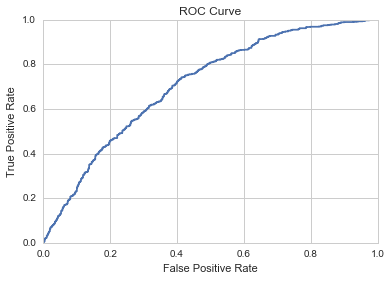

ROC AUC: 0.708


In [87]:
# Plot ROC curve and get AUC score
y_pred_proba = lm.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba)

 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, y_pred_proba)

In [88]:
# Set list of values to grid search over
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
s = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
params = {'C': c, 'solver':s}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

Best Params:
{'C': 0.01, 'solver': 'newton-cg'}
Accuracy of current model: 0.677
Accuracy using best param: 0.768


In [89]:
# Current model params
print lm
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)

# Update model params
lm.set_params(C=0.01)
lm.set_params(solver='newton-cg')

# Retrain model on new params
lm.fit(X_train, y_train)

# Updated model params
print lm
print "Accuracy of updated model: %0.3f" % lm.score(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of current model: 0.677
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of updated model: 0.778


In [90]:
df_train = pd.read_csv("../data/final/final.csv")

df_train.head()

,year,decade,total_curses,curses,unique_words,density,creativity,charted
0,1961,1960,0,0,37,73,0.506849,0
1,1961,1960,0,0,45,91,0.494505,1
2,1961,1960,0,0,56,106,0.528302,1
3,1961,1960,0,0,42,148,0.283784,1
4,1961,1960,0,0,29,132,0.219697,1


In [91]:
# Set target variable name
target = 'charted'

# Set X_train and y_train
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]

In [92]:

# Build tuned model
lm = linear_model.LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

# Train tuned model
lm.fit(X_train, y_train)

# Score tuned model
print "Accuracy: %0.3f" % lm.score(X_train, y_train)

Accuracy: 0.775


In [93]:
# Generate probabililty of charted using trained model
df_train['Probability'] = lm.predict_proba(X_train)[:,1]

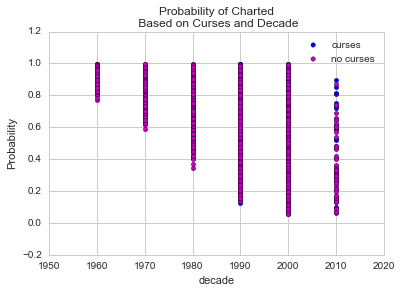

In [94]:
# Plot Probability of Survivial Based on Sex and Age
ax = df_train[df_train['curses']==1].plot(
    x='decade', y='Probability', kind='scatter', color='b', label='curses'
)
df_train[df_train['curses']==0].plot(
    ax=ax, x='decade', y='Probability', kind='scatter', color='m', label='no curses'
)
ax.set(title='Probability of Charted\n Based on Curses and Decade')